In [1]:
import open3d as o3d
import copy 
import numpy as np 
import time
from scipy import spatial
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd 
from utils import *
from utils.draw import *

# Input of Source Point Cloud and the Target Point Cloud

In [2]:
if __name__=='__main__': 
    p1 = [667.11, -107.69, 260.41]
    p2 = [667.81, -147.03, 256.54]
    p3 = [663.75, -147.03, 279.01]

    #-----------------------target-----------------------#
    target = o3d.io.read_point_cloud('./Workpieces/PCD/target.pcd')
    #-----------------------source-----------------------#
    source = o3d.io.read_point_cloud('./Workpieces/PCD/second_source.pcd')  
    print("yes")
    
    source_orig_pd = pd.DataFrame(source.points, columns =["X", "Y", "Z"])
    
    # threshold = 0.00002
    trans_init = np.asarray([[1.0, 0.0, 0.0, 662.6], [0.0, 1.0, 0.0, -171],
                              [0.0, 0.0, 1.0, 279.253], [0.0, 0.0, 0.0, 1.0]])

    rot_degree = np.radians(7.6)
    trans_rot = np.asarray([[1.0, 0.0, 0.0, 0.0], [0 , np.cos(rot_degree), -np.sin(rot_degree), 0],
                            [0 , np.sin(rot_degree), np.cos(rot_degree), 0], [0.0, 0.0, 0.0, 1.0]])

    trans_ = np.asarray([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 36.5],
                              [0.0, 0.0, 1.0, 19.3], [0.0, 0.0, 0.0, 1.0]])
    
    radian_ = np.radians(180)
    trans_2 = np.asarray([[np.cos(radian_), -np.sin(radian_), 0.0, 0.0], [np.sin(radian_), np.cos(radian_), 0.0, 0.0],
                              [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    trans_3 = np.asarray([[1.0, 0.0, 0.0, 37.0], [0.0, 1.0, 0.0, 108],
                              [0.0, 0.0, 1.0, 29], [0.0, 0.0, 0.0, 1.0]])
    trans_init2 =  trans_3 @ trans_rot @ trans_init @ trans_2

: 

: 

# Statistical Oulier Removal

In [54]:

    print("Statistical oulier removal")
    cl, ind = source.remove_statistical_outlier(nb_neighbors=20,
                                            std_ratio=3.0)

Statistical oulier removal


# Voxel Downsampling

In [55]:
    uni_down_cl = cl.uniform_down_sample(every_k_points=10)
    uni_down_cl_pd = pd.DataFrame(uni_down_cl.points, columns =["X", "Y", "Z"])
    
    uni_down_target = target.uniform_down_sample(every_k_points=3)
    uni_down_target_pd = pd.DataFrame(uni_down_target.points, columns =["X", "Y", "Z"])

# Iterative Closest Point (ICP)

In [56]:
    """Point-to-plane
    registration_icp is called with a different parameter TransformationEstimationPointToPlane.     Internally, this class implements functions to compute the residuals and 
    Jacobian matrices of the point-to-plane ICP objective.
    
    """
    print("Apply point-to-plane ICP")
    # threshold = 200
    threshold = 2
    start = time.time()
    # radius=0.1 -> 10cm 
    uni_down_cl.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=5000))
    
    target.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=5000)) 
    
    reg_p2l = o3d.pipelines.registration.registration_icp(
        uni_down_cl, target, threshold, trans_init2,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())    
    
    print("Point-to-plane ICP registration took %.3f sec.\n" % (time.time() - start))
    print(reg_p2l)
    print("Transformation is:")
    print(reg_p2l.transformation)

Apply point-to-plane ICP
Point-to-plane ICP registration took 2.411 sec.

RegistrationResult with fitness=8.308424e-01, inlier_rmse=8.230482e-01, and correspondence_set size of 20624
Access transformation to get result.
Transformation is:
[[-9.99668369e-01 -3.33592888e-03  2.55347544e-02  7.06838539e+02]
 [ 2.28882886e-04 -9.92685778e-01 -1.20726525e-01 -9.51039454e+01]
 [ 2.57507227e-02 -1.20680644e-01  9.92357336e-01  2.83482845e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [57]:
    """Point-to-point"""
    print("Apply point-to-point ICP")
    threshold = 0.2
    reg_p2p = o3d.pipelines.registration.registration_icp(
        uni_down_cl, target, threshold, trans_init2,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=200000))
    print(reg_p2p)
    print("Transformation is:")
    print(reg_p2p.transformation)

Apply point-to-point ICP
RegistrationResult with fitness=8.931233e-01, inlier_rmse=1.057176e-01, and correspondence_set size of 22170
Access transformation to get result.
Transformation is:
[[-9.99854401e-01  1.44343659e-02  9.10083484e-03  6.99790869e+02]
 [-1.54414674e-02 -9.92340837e-01 -1.22561102e-01 -9.79463293e+01]
 [ 7.26203828e-03 -1.22683787e-01  9.92419242e-01  2.82527603e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [ ]:
    source = cl.transform(reg_p2p.transformation) 
    draw_registration_result(source, target)

In [10]:
    source_pd = pd.DataFrame(source.points, columns =["X", "Y", "Z"])
    source_pd.insert(0, "Color", "Source")

    target_pd = pd.DataFrame(target.points, columns =["X", "Y", "Z"])
    target_pd.insert(0, "Color", "Target")

# Outlier Removal 

In [12]:
    """Outlier"""
    target_pd_xyz = target_pd[["X", "Y", "Z"]]
    kdtree = spatial.cKDTree(target_pd_xyz)     
    query_xyz = source_pd[["X", "Y", "Z"]]      
    dd, ii = kdtree.query(query_xyz, k=1, p=2, workers=-1)
    i_list = None
    source_len = len(source_pd)
    dd_threshold = 0.5
    for i in range(source_len):
        if dd[i] > dd_threshold:
            source_pd.loc[i, "Color"] = "Outlier" 
    draw_outlier_result(source_pd[source_pd["Color"] == "Source"], source_pd[source_pd["Color"] == "Outlier"])
#%%
    source_pd = source_pd[source_pd["Color"] == "Source"]
#%%
    draw_pd_result(source_pd, target_pd)

# Attention of Target Point Cloud

In [13]:
target_pd_trim = PdTrimThroughPlane(target_pd, p1, p2, p3, offset = 30000)

# Visualization of Hyperplane

In [48]:
    vertical_stack = pd.concat([source_pd, target_pd_trim], axis=0)
    fig = px.scatter_3d(vertical_stack, x='X', y='Y', z='Z', color_discrete_sequence=["blue", "green"],
                  color='Color')
    x0, y0, z0 = p1
    x1, y1, z1 = p2
    x2, y2, z2 = p3
    
    ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
    vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]
    
    u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]
    
    point  = np.array(p1)
    normal = np.array(u_cross_v)
    
    d = -point.dot(normal)
    x = np.linspace(640, 680, 10)
    y = np.linspace(-145, -100, 10)
    xx, yy = np.meshgrid(x, y)
    
    z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]
   
    import plotly.graph_objects as go
    fig.add_trace(go.Surface(z=z, x=xx, y=yy))    
   
    fig.write_html('Visualization of Hyperplane.html', auto_open=True)

KeyError: (nan, '', '')

# Attention of Source and Target

In [16]:
    len_local_space = 1000
    target_pd_trim = PdTrimThroughPlane(target_pd, p1, p2, p3, offset = len_local_space)
    source_pd_trim = PdTrimThroughPlane(source_pd, p1, p2, p3, offset = len_local_space)
    draw_pd_result(source_pd_trim, target_pd_trim) 


# ICP again!

In [18]:
    source_pd_trim = source_pd_trim[["X", "Y", "Z"]]
    target_pd_trim = target_pd_trim[["X", "Y", "Z"]]
    
    trans_init2 = np.asarray([[1.0, 0.0, 0.0, 0], [0.0, 1.0, 0.0, 0],
                              [0.0, 0.0, 1.0, 0], [0.0, 0.0, 0.0, 1.0]])
    
    source2 = o3d.geometry.PointCloud()
    target2 = o3d.geometry.PointCloud()
    
    source2.points = o3d.utility.Vector3dVector(source_pd_trim.to_numpy())
    target2.points = o3d.utility.Vector3dVector(target_pd_trim.to_numpy())
    
    trans_init3 = np.asarray([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0],
                              [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    reg_p2p2 = o3d.pipelines.registration.registration_icp(
        source2, target2, threshold, trans_init3,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=20000))
    print(reg_p2p2)
    print("Transformation is:")
    print(reg_p2p2.transformation)
    # draw_pd_result(source_pd_trim, target_pd_trim, reg_p2p2.transformation)
    row_lables = source_pd_trim.index.values
    source2 = source2.transform(reg_p2p2.transformation)
    source_pd_trim = pd.DataFrame(source2.points, columns =["X", "Y", "Z"])
    source_pd_trim.index = row_lables
    draw_pd_result(source_pd_trim, target_pd_trim)

RegistrationResult with fitness=9.201720e-01, inlier_rmse=1.025648e-01, and correspondence_set size of 7919
Access transformation to get result.
Transformation is:
[[ 9.99969051e-01 -3.50721337e-03 -7.04244689e-03  1.52136144e+00]
 [ 3.50019367e-03  9.99993365e-01 -1.00884799e-03 -2.10237356e+00]
 [ 7.04593841e-03  9.84166838e-04  9.99974693e-01 -4.56951238e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


# Defination of Direction

In [19]:
    scan_dir = "Y" ## x axis
    norm_dir = "X"
    high_dir = "Z"


# Source Profile

In [20]:
    source_corr_drop, source_corr_trim = SourceProfile(source_pd_trim, scan_dir, norm_dir, high_dir)
    draw_pd_result(source_corr_drop, source_corr_trim)

# Target Profile

C:\Users\IanChen\Miniconda3\envs\workspace\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



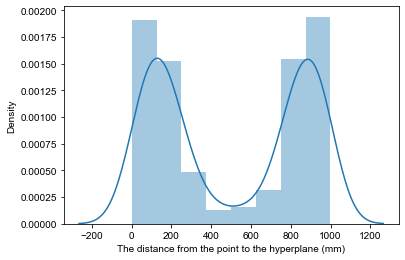

C:\Users\IanChen\Miniconda3\envs\workspace\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



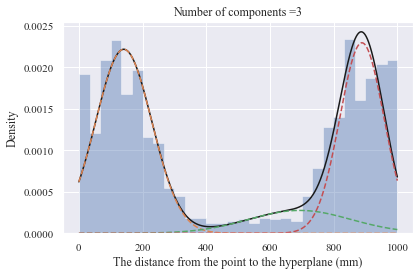

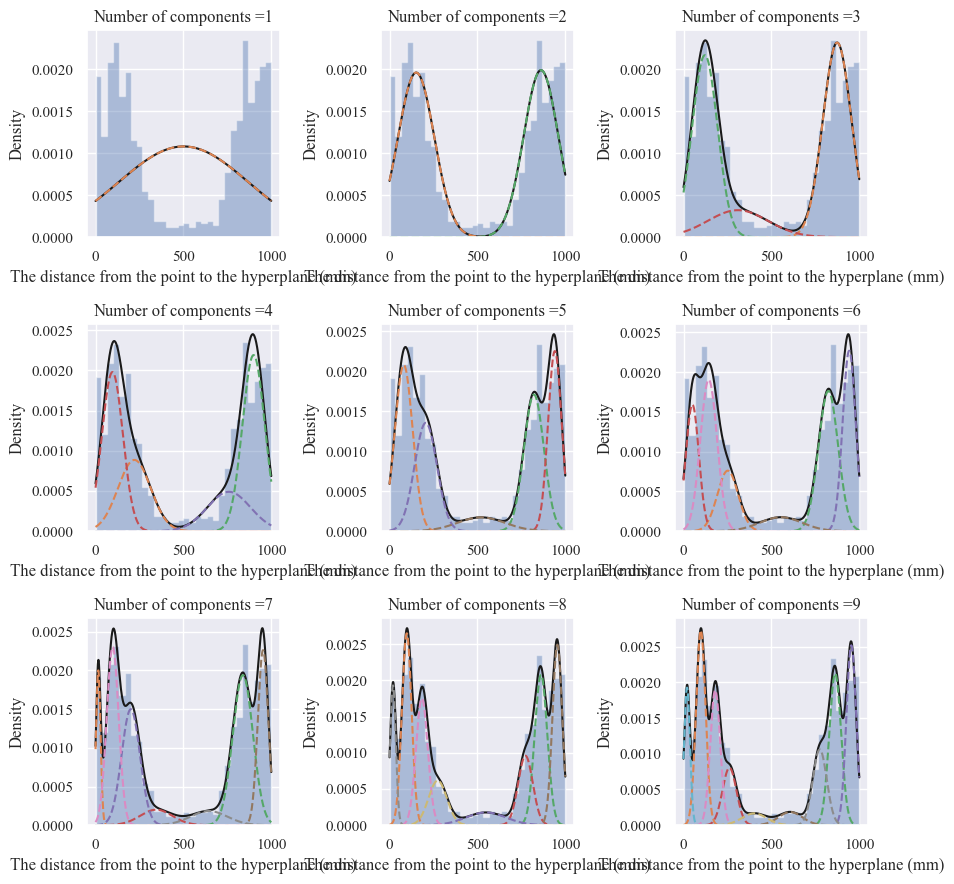

In [21]:
    target_corr_drop, target_corr_trim = TargetProfile(target_pd_trim, p1, p2 ,p3, len_local_space)
    draw_pd_custom_result(target_corr_drop, target_corr_trim, [0, 1, 0], [127/255, 0, 1])

In [24]:
    target_corr_trim["Color"] = "Target"
    target_corr_drop["Color"] = "Drop"
    vertical_stack = pd.concat([target_corr_drop, target_corr_trim], axis=0)
    fig = px.scatter_3d(vertical_stack, x='X', y='Y', z='Z', color_discrete_sequence=["green", "goldenrod"],
                  color='Color')
    x0, y0, z0 = p1
    x1, y1, z1 = p2
    x2, y2, z2 = p3
    
    ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
    vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]
    
    u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]
    
    point  = np.array(p1)
    normal = np.array(u_cross_v)
    
    d = -point.dot(normal)
    x = np.linspace(663.5, 667.5, 10)
    y = np.linspace(-145, -110, 10)
    xx, yy = np.meshgrid(x, y)
    
    z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]
    import plotly.graph_objects as go
    fig = go.Figure(data=[go.Surface(z=z, x=xx, y=yy)])
    # fig.add_trace(go.Surface(z=z, x=xx, y=yy))    
    fig.write_html('3D.html', auto_open=True)
    draw_one_pd_result(target_corr_trim, [0, 1, 0])

# 3D Visualiztion of Target 

In [25]:
    target_corr_trim["Color"] = "Target"
    fig = px.scatter_3d(target_corr_trim, x='X', y='Y', z='Z',
                  color='Color', color_discrete_sequence=["greenyellow"])

    fig.write_html('3D.html', auto_open=True)

    draw_one_pd_result(target_corr_trim, [0, 1, 0])

# Dimension Reduction with Hyperplane 

In [27]:
    print("Source and Target: Projection!")
    PdProject(source_corr_trim, p1, p2, p3, ["X", "Y", "Z"], ["PX", "PY", "PZ"])
    PdProject(target_corr_trim, p1, p2, p3, ["X", "Y", "Z"], ["PX", "PY", "PZ"])

#%%
    """Rotate to Z axis"""
    p_a, p_b, p_c ,p_d = GetPlaneEq(p1, p2, p3)
    vec1 = [p_a, p_b, p_c]
    vec2 = [0, 1, 0]
    a,b = (vec1/ np.linalg.norm(vec1)).reshape(3), (vec2/np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a,b)
    c = np.dot(a,b)
    s = np.linalg.norm(v)
    vXStr = '{} {} {}; {} {} {}; {} {} {}'.format(0, -v[2], v[1], v[2], 0, -v[0], -v[1], v[0], 0)
    k = np.matrix(vXStr)
    I = np.identity(3)
    r = I + k + k @ k * ((1 -c)/(s**2))
    rm = np.empty((4, 4))
    rm[:3, :3] = r

#%%
    """Projection of Source aligns to XZ plane"""
    r_pd = pd.DataFrame(r);
    print("Source: Get 2D coordinates!")
    Pd3DPlaneto2D(source_corr_trim, p1, p2, p3, ["PX", "PY", "PZ"], ["U", "V"])
    
#%%
    """Projection of Target aligns to XZ plane"""
    print("Target: Get 2D coordinates!")
    Pd3DPlaneto2D(target_corr_trim, p1, p2, p3, ["PX", "PY", "PZ"], ["U", "V"])

#%%
    """Source PC2 aligns to XZ plane"""
    print("PC2 of Source: Projectin and Get 2D coordinates!")
    PdProject(source_corr_trim, p1, p2, p3, ["PC2X", "PC2Y", "PC2Z"], ["PPC2X", "PPC2Y", "PPC2Z"])
    Pd3DPlaneto2D(source_corr_trim, p1, p2, p3, ["PPC2X", "PPC2Y", "PPC2Z"], ["PC2U", "PC2V"])
    
    """Target PC2 aligns to XZ plane"""
    print("PC2 of Target: Projectin and Get 2D coordinates!")
    PdProject(target_corr_trim, p1, p2, p3, ["PC2X", "PC2Y", "PC2Z"], ["PPC2X", "PPC2Y", "PPC2Z"])
    Pd3DPlaneto2D(target_corr_trim, p1, p2, p3, ["PPC2X", "PPC2Y", "PPC2Z"], ["PC2U", "PC2V"])
    
#%%
    """Target Normal aligns to XZ"""
    print("Normal of Target: Projectin and Get 2D coordinates!")
    PdProject(target_corr_trim, p1, p2, p3, ["NormalX", "NormalY", "NormalZ"], ["PNormalX", "PNormalY", "PNormalZ"])
    Pd3DPlaneto2D(target_corr_trim, p1, p2, p3, ["PNormalX", "PNormalY", "PNormalZ"], ["NormalU", "NormalV"])
    
    u_tan = -target_corr_trim.NormalV
    v_tan =  target_corr_trim.NormalU
    
    target_corr_trim["UTAN"] = np.asarray(u_tan).tolist()
    target_corr_trim["VTAN"] = np.asarray(v_tan).tolist()

Source and Target: Projection!
Source: Get 2D coordinates!
Target: Get 2D coordinates!
PC2 of Source: Projectin and Get 2D coordinates!
PC2 of Target: Projectin and Get 2D coordinates!
Normal of Target: Projectin and Get 2D coordinates!


# Visualization of Dimension Reduction with Hyperplane 

In [28]:
    target_corr_trim["Color"] = "Target"
    source_corr_trim["Color"] = "Source"
    all_points = source_corr_trim.append(target_corr_trim, ignore_index = True) 
  
    fig = px.scatter(all_points[["U", "V", "Color"]], x = "U", y = "V", color='Color',
                      color_discrete_sequence=["blue", "green"])    
    fig.write_html('Workpieces.html', auto_open=True) 
    

# Manifold Mapping Algorithm

In [29]:
    MF = Manifold(source_corr_trim, target_corr_trim, ["U", "V"], "OFF")
    source_new_np, target_new_np, source_index_list, target_index_list, angle_np, r_angle_np, delta, _ = MF.unfold()
    source_proj_r = copy.deepcopy(source_corr_trim)

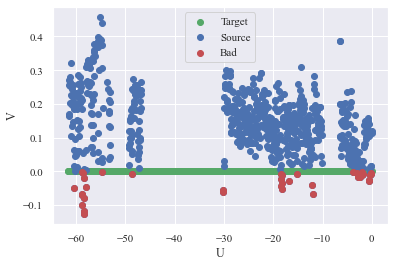

In [37]:
    neg_index = np.where(source_new_np[:, 1] < 0.0)
    u_new = target_new_np[:,0]
    u_new = np.append(u_new, source_new_np[:,0])
    u_new = np.append(u_new, source_new_np[neg_index, 0])
#%%
    v_new = target_new_np[:,1]
    v_new = np.append(v_new, source_new_np[:,1])
    v_new = np.append(v_new, source_new_np[neg_index, 1])
#%%
    color_new = ["Target"]*len(target_new_np[:,0])
    color_new = color_new + ["Source"]*len(source_new_np[:,0])
    color_new = color_new + ["Bad"]*len(source_new_np[neg_index, 0][0])
    
#%%
    all_points_dict = {"U": u_new,
                       "V": v_new,
                       "Color": color_new
                       }
    all_points = pd.DataFrame(all_points_dict)
    fig = px.scatter(all_points[["U", "V", "Color"]], x = "U", y = "V", color='Color',
                      color_discrete_sequence=["green", "blue", "red"])   
    fig.write_html('Manifold Mapping.html', auto_open=True)  
    
    """matplot """
    fig, ax = plt.subplots()
    ax.scatter(all_points[all_points["Color"] == "Target"].U, all_points[all_points["Color"] == "Target"].V, color='g',label="Target")
    ax.scatter(all_points[all_points["Color"] == "Source"].U, all_points[all_points["Color"] == "Source"].V, color='b',label="Source")
    ax.scatter(all_points[all_points["Color"] == "Bad"].U, all_points[all_points["Color"] == "Bad"].V, color='r',label="Bad")
    plt.xlabel("U")
    plt.ylabel("V")
    plt.legend()
    plt.show()

## Map to Original Space

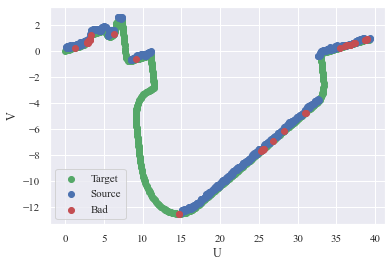

In [35]:
    neg_index = np.where(source_new_np[:, 1] <= 0.0)
    source_index_np = np.hstack(source_index_list)
    neg_index_ = source_index_np[neg_index]
    source_proj_r.loc[neg_index_, 'Color'] = "Bad"
    all_points = source_proj_r.append(target_corr_trim[["U", "V", "Color"]], ignore_index = True)   
    fig = px.scatter(all_points[["U", "V", "Color"]], x = "U", y = "V", color='Color',
                      color_discrete_sequence=["blue", "red", "green"])    
    fig.write_html('Workpieces.html', auto_open=True)  
    """matplot """
    fig, ax = plt.subplots()
    ax.scatter(all_points[all_points["Color"] == "Target"].U, all_points[all_points["Color"] == "Target"].V, color='g',label="Target")
    ax.scatter(all_points[all_points["Color"] == "Source"].U, all_points[all_points["Color"] == "Source"].V, color='b',label="Source")
    ax.scatter(all_points[all_points["Color"] == "Bad"].U, all_points[all_points["Color"] == "Bad"].V, color='r',label="Bad")
    plt.xlabel("U")
    plt.ylabel("V")
    plt.legend()
    plt.show()
    

# Responding Searching Algorithm

In [46]:
    inspection = Inspection(source_proj_r_, target_corr_trim, 0.2, ["U", "V"], ["UTAN", "VTAN"], 6, "No")
    source_proj_r2, target_proj_r2, source_proj_r2_corresponding, dist_list = inspection.calculate_distance()
    all_xyz_burr = pd.concat([source_proj_r2, target_proj_r2]) 
    fig = px.scatter(all_xyz_burr, x = "U", y = "V", color='Color', 
                      color_discrete_sequence=["red", "blue", "purple", "green", "yellow"])
                      
    fig.write_html('Burr Inspection.html', auto_open=True) 